In [7]:
from __future__ import division
import numpy as np
import pandas as pd
from IOHMM import UnSupervisedIOHMM
from IOHMM import OLS, DiscreteMNL, CrossEntropyMNL
import glob
from dataclasses import dataclass
import dataclasses
from matplotlib import pyplot as plt
import math

In [8]:
@dataclass
class interpolated_gt_data:
    id        : int   
    frameID   : int
    position_x: float
    position_y: float
    position_z: float
    theta     : float
    length    : float
    width     : float
    height    : float
    type      : str   
    time_stamp: float
    # 
    currentDet: bool
    previousDet: bool
    # Ego pose at same time_stamp
    ego_position_x: float
    ego_position_y: float
    ego_position_z: float
    ego_theta     : float

class Trajectory():
    # Record the trajectory of each object (specific by unique ID)
    # For ID switch case, it will be recordedin the obj_list dict
    #
    def __init__(self, ID):
        self.ID = ID
        self.obj_list = dict() # List of interpolated_gt_data
        self.timeline = dict()
        self.startFrame = math.inf
        self.endFrame = 0

    def __jsonencode__(self):
        # Use the local dictionary to serizalize th DT and GT
        local_obj_list = dict()
        local_timeline = dict()
        for (idx,obj) in zip(self.obj_list.keys(), self.obj_list.values()):
            local_obj_list[idx] = dataclasses.asdict(obj)
        for (idx,obj) in zip(self.timeline.keys(),self.timeline.values()):
            local_timeline[idx] = dataclasses.asdict(obj)

        return  {'ID':self.ID,'obj_list':local_obj_list,'timeline':local_timeline,\
                 'startFrame':self.startFrame,'endFrame':self.endFrame}

    def addObject(self, obj,frameID):
        # Take the obj.id as the frame indices
        # for key: obj ID, record obj
        # self.obj_list[obj.id] = obj
        # self.startFrame = min(self.startFrame,obj.id)
        # self.endFrame   = max(self.endFrame,obj.id)
        # self.startFrame = min(self.startFrame,obj.frameID)
        # self.endFrame   = max(self.endFrame,obj.frameID)
        # self.obj_list[obj.time_stamp] = obj
        self.obj_list[frameID] = obj
        self.startFrame = min(self.startFrame,frameID)
        self.endFrame   = max(self.endFrame,frameID)

    def addPairing(self,detObj,frameID):
        # Only the gtTrajectory will call this function
        self.timeline[frameID] = detObj
    
    def makeAttributes(self):
        '''
        '''
        for frameID in range(self.startFrame,self.endFrame+1):
            if frameID in self.obj_list.keys():
            #    self.objList[frameID].firstAppear = False #bool if this obj is first time in GT
                if frameID in self.timeline.keys():
                    # print('frameID:',frameID)
                    self.obj_list[frameID].currentDet = True
                else:
                    self.obj_list[frameID].currentDet = False

                if frameID-1 in self.timeline.keys() and frameID-1 in self.obj_list.keys() :
                    # print('frameID-1:',frameID-1)
                    self.obj_list[frameID].previousDet = True
                    # self.obj_list[frameID].previousPair = self.obj_list[frameID-1].Pair
                else:
                    self.obj_list[frameID].previousDet = False #bool if this obj was detected previous frame

    def plot_trajectory(self,ego_list):
        '''
        Plot trajectory of the objects 
        '''
        fig = plt.figure()
        ax = fig.add_subplot(111)
        # Plot the interpolated ground truth
        for obj in self.obj_list.values():
            plt.plot(obj.position_x,obj.position_y,'bo',markersize=1)
            ax.add_patch(Rec(xy=(obj.position_x-(obj.length/2),obj.position_y-(obj.width/2)),width=obj.length,height=obj.width,angle=obj.theta*180/math.pi,color='blue',rotation_point='center',fill=False))
            plt.arrow(obj.position_x,obj.position_y,math.cos(obj.theta),math.sin(obj.theta),width=0.1,color='blue')
            # ego_pose = [ego for ego in ego_list if ego.time_stamp == obj.time_stamp]
            # if ego_pose != []:
            #     ax.scatter(ego_pose[0].ego_position_x,ego_pose[0].ego_position_y,s=2,color='red')
            #     Angle = Quaternion(ego_pose[0].orientation_qw,ego_pose[0].orientation_qx,ego_pose[0].orientation_qy,ego_pose[0].orientation_qz).to_euler().yaw
            #     plt.arrow(ego_pose[0].ego_position_x,ego_pose[0].ego_position_y,math.cos(Angle),math.sin(Angle),width=0.1,color='black')

            # plt.title("Timestamp:{},(Frame ID:{})".format(obj.time_stamp,obj.frameID))
            # plt.legend('Interpolated GT','Ego Pose','GT in prev. frame','GT in next frame')
            # plt.legend(prop = {'size': 6})
            # plt.xlim(330,455)
            # plt.ylim(1075,1230)
            # plt.savefig('./render_traj/'+str(obj.frameID))
        

        # Plot the matched result
        # fig2 = plt.figure()
        # ax2 = fig2.add_subplot(111)
        ax2 = ax
        for obj in self.timeline.values():
            ax2.scatter(obj.position_x,obj.position_y,color='red',s=2)
            ax2.add_patch(Rec(xy=(obj.position_x-(obj.length/2),obj.position_y-(obj.width/2)),width=obj.length,height=obj.width,angle=obj.theta*180/math.pi,color='red',rotation_point='center',fill=False))
            plt.arrow(obj.position_x,obj.position_y,math.cos(obj.theta),math.sin(obj.theta),width=0.1,color='red')
            
        plt.title("Timestamp:{},(GT Obj ID:{})".format(obj.time_stamp,self.ID))
            # plt.legend('Interpolated GT','Ego Pose','GT in prev. frame','GT in next frame')
            # plt.legend(prop = {'size': 6})
        # plt.xlim(600,700)
        # plt.ylim(1580,1680)
        # plt.xlim(330,440)
        # plt.ylim(1080,1220)
        # plt.savefig('./render_traj/DT/'+str(self.ID))
        plt.close()

In [9]:
class SceneFrames(object):
    def __init__(self, id):
        self.id         = id
        self.gtTrajDict = dict() # dict of Trajectory

# Load data

In [115]:
import json
DATASET_PATH = glob.glob('/home/francis/Desktop/internship/matching/AIOHMM_dataset_radar*.json')
print('DATASET_PATH:',DATASET_PATH)
PairedSceneListSun = dict()
PairedSceneListRain = dict()
PairedSceneListNight = dict()
PairedSceneListRainNight = dict()

for OneCondition in DATASET_PATH:
    ConditionFlag = OneCondition.split('_')[-1].split('.')[0]
    print(ConditionFlag)
    if ConditionFlag.lower() == 'sun':
        PairedSceneList = PairedSceneListSun
    elif ConditionFlag.lower() == 'rain':
        PairedSceneList = PairedSceneListRain
    elif ConditionFlag.lower() == 'night':
        PairedSceneList = PairedSceneListNight
    elif ConditionFlag.lower() == 'rainynight':
        PairedSceneList = PairedSceneListRainNight
    else:
        raise ValueError('No this weather condition is not valid')
    
    with open(OneCondition) as f:
        DatasetOneWeather = json.load(f)
        for (SceneToken,TrajectoryDict) in DatasetOneWeather.items():
            # print(SceneToken)
            obj_dict = dict()
            for (ObjID,Traj) in TrajectoryDict['gtTrajDict'].items():
                ObjTraj = Trajectory(ObjID)
                ObjTraj.obj_list = Traj['obj_list']
                ObjTraj.timeline = Traj['timeline']
                ObjTraj.startFrame = Traj['startFrame']
                ObjTraj.endFrame = Traj['endFrame']
                obj_dict[ObjID] = ObjTraj
            
            PairedSceneList[SceneToken] = obj_dict

DATASET_PATH: ['/home/francis/Desktop/internship/matching/AIOHMM_dataset_radar_night.json', '/home/francis/Desktop/internship/matching/AIOHMM_dataset_radar_sun.json', '/home/francis/Desktop/internship/matching/AIOHMM_dataset_radar_RainyNight.json', '/home/francis/Desktop/internship/matching/AIOHMM_dataset_radar_rain.json']
night
sun
RainyNight
rain


In [81]:
sun = glob.glob('/home/francis/Desktop/internship/apollo/HMM_dataset/text_dataset/ground_truth/*_sun.txt')
night = glob.glob('/home/francis/Desktop/internship/apollo/HMM_dataset/text_dataset/ground_truth/*_night.txt')
rain = glob.glob('/home/francis/Desktop/internship/apollo/HMM_dataset/text_dataset/ground_truth/*_rain.txt')

print('sun:',len(sun))

print('night:',len(night))

print('rain:',len(rain))

sun: 30
night: 33
rain: 30


In [38]:
print(10962/71,9603/80,1246/10)
print(15897/108)

154.3943661971831 120.0375 124.6
147.19444444444446


# Preprocessing
1. Transform from global coordinate to local coordinate wrt to ego pose in polar      
   coorindate.
2. Prepare input output vector (r_in,theta_in), (r_out, theta_out) to list of dataframes
3. Imputation of missing observations by adding the mean error with the GT.   


In [11]:
def get_df(PairedSceneList):
    ''' Convert to local coordinate without imputattion row by row '''
    df = pd.DataFrame()
    for OneScene in PairedSceneList.values():
        for ObjTraj in OneScene.values():
            Noise_R = list()
            Noise_theta = list()
            Prescene_list = list()
            Visibility_list = list()
            frame_list = list(range(ObjTraj.startFrame,ObjTraj.endFrame+1))
            detect_frame = list((ObjTraj.timeline.keys()))
            detect_frame = [int(x) for x in detect_frame]
            # print("Debug:")
            # print("From frame {} to frame {}:{}".format(ObjTraj.startFrame,ObjTraj.endFrame,frame_list))
            # print("Detected frame(len:{}):{}".format(len(detect_frame),detect_frame))
            for FrameID in frame_list:
                if FrameID in detect_frame:
                    # For one objectTraj, will contribute to 2 columns x number of frames in the dataframe
                    GTTraj = ObjTraj.obj_list[str(FrameID)]
                    GTLocalX = GTTraj['position_x'] - GTTraj['ego_position_x']
                    GTLocalY = GTTraj['position_y'] - GTTraj['ego_position_y']
                    GTLocalZ = GTTraj['position_z'] - GTTraj['ego_position_z']
                    DTTraj = ObjTraj.timeline[str(FrameID)]
                    DTLocalX = DTTraj['position_x'] - GTTraj['ego_position_x']
                    DTLocalY = DTTraj['position_y'] - GTTraj['ego_position_y']
                    DTLocalZ = DTTraj['position_z'] - GTTraj['ego_position_z']
                    visibility_flag = GTTraj['visibility']
                    # Transform GT/DT local coordiante
                    DTLocalR = np.float64(math.sqrt(DTLocalX**2+DTLocalY**2+DTLocalZ**2))
                    DTLocalTheta = np.float64(DTTraj['theta']-GTTraj['ego_theta']+math.pi/2)
                    GTLocalR = np.float64(math.sqrt(GTLocalX**2+GTLocalY**2+GTLocalZ**2))
                    GTLocalTheta = np.float64(GTTraj['theta']-GTTraj['ego_theta']+math.pi/2)
                    DT_R = np.float64(DTLocalR)
                    DT_theta = np.float64(DTLocalTheta)
                    GT_R = np.float64(GTLocalR)
                    GT_theta = np.float64(GTLocalTheta)
                    Noise_R.append(np.float64(DT_R-GT_R))
                    Noise_theta.append(np.float64(DT_theta-GT_theta))
                    Visibility_list.append(visibility_flag)
                    Prescene_list.append(1)
                else:
                    Noise_R.append(np.nan)
                    Noise_theta.append(np.nan)
                    Visibility_list.append(np.nan)
                    Prescene_list.append(0)
               
            # If regardless the id of obj, then the idx of id would repeated since mix the scenes
            # If there is only one pair (only 1 frame) in the df_onescene, then ignore this obj
            if (len(detect_frame)) > 100:
                new_row = {'Noise_R':Noise_R,'Noise_T':Noise_theta,'Prescence':Prescene_list,'Visibility':Visibility_list}
                # print(new_row)
                df = df.append(new_row,ignore_index=True)
            else:
                continue
    return df

In [12]:
# df_sun = get_df(PairedSceneListSun)
# df_sun.head()
# df_sun.to_csv('./df_sun_withMissing.csv',index=False)
# df_train,df_test = train_test_split(df_sun,test_size=0.2,random_state=42)
# df_train.to_csv('df_sun_train_withMissing.csv',index=False)
# df_test.to_csv('df_sun_test_withMissing.csv',index=False)

# Prepare noise data and miss/detect for HMM training

In [13]:
def get_df_data_imputation_HMM(PairedSceneList):
    df = pd.DataFrame()
    for OneScene in PairedSceneList.values():
        for ObjTraj in OneScene.values():
            df_onescene = pd.DataFrame()
            error_r = list()
            error_theta = list()
            for (DTFrameID,DTTraj) in ObjTraj.timeline.items():
                # For one objectTraj, will contribute to 2 columns x number of frames in the dataframe
                GTTraj = ObjTraj.obj_list[DTFrameID]
                GTLocalX = GTTraj['position_x'] - GTTraj['ego_position_x']
                GTLocalY = GTTraj['position_y'] - GTTraj['ego_position_y']
                GTLocalZ = GTTraj['position_z'] - GTTraj['ego_position_z']
                DTLocalX = DTTraj['position_x'] - GTTraj['ego_position_x']
                DTLocalY = DTTraj['position_y'] - GTTraj['ego_position_y']
                DTLocalZ = DTTraj['position_z'] - GTTraj['ego_position_z']
                # Transform GT/DT local coordiante
                DTLocalR = np.float64(math.sqrt(DTLocalX**2+DTLocalY**2+DTLocalZ**2))
                DTLocalTheta = np.float64(DTTraj['theta']-GTTraj['ego_theta']+math.pi/2)
                GTLocalR = np.float64(math.sqrt(GTLocalX**2+GTLocalY**2+GTLocalZ**2))
                GTLocalTheta = np.float64(GTTraj['theta']-GTTraj['ego_theta']+math.pi/2)
                error_r.append(DTLocalR-GTLocalR)
                error_theta.append(DTLocalTheta-GTLocalTheta)

            prevID = 0
            for (DTFrameID,DTTraj) in ObjTraj.timeline.items():
                if (int(DTFrameID) == prevID+1):
                    # For one objectTraj, will contribute to 2 columns x number of frames in the dataframe
                    Presence_flag = 1
                    visility_flag = 1
                    GTTraj = ObjTraj.obj_list[DTFrameID]
                    GTLocalX = GTTraj['position_x'] - GTTraj['ego_position_x']
                    GTLocalY = GTTraj['position_y'] - GTTraj['ego_position_y']
                    GTLocalZ = GTTraj['position_z'] - GTTraj['ego_position_z']
                    DTLocalX = DTTraj['position_x'] - GTTraj['ego_position_x']
                    DTLocalY = DTTraj['position_y'] - GTTraj['ego_position_y']
                    DTLocalZ = DTTraj['position_z'] - GTTraj['ego_position_z']
                    visibility_flag = GTTraj['visibility']
                    # Transform GT/DT local coordiante
                    DTLocalR = np.float64(math.sqrt(DTLocalX**2+DTLocalY**2+DTLocalZ**2))
                    DTLocalTheta = np.float64(DTTraj['theta']-GTTraj['ego_theta']+math.pi/2)
                    GTLocalR = np.float64(math.sqrt(GTLocalX**2+GTLocalY**2+GTLocalZ**2))
                    GTLocalTheta = np.float64(GTTraj['theta']-GTTraj['ego_theta']+math.pi/2)
                    #
                    DT_R = np.float64(DTLocalR)
                    DT_theta = np.float64(DTLocalTheta)
                    GT_R = np.float64(GTLocalR)
                    GT_theta = np.float64(GTLocalTheta)


                   
                else: # DTFrameID != prevID+1, means there is missing frameID
                    Presence_flag = 0
                    GTTraj = ObjTraj.obj_list[DTFrameID]
                    GTLocalX = GTTraj['position_x'] - GTTraj['ego_position_x']
                    GTLocalY = GTTraj['position_y'] - GTTraj['ego_position_y']
                    GTLocalZ = GTTraj['position_z'] - GTTraj['ego_position_z']
                    DTLocalX = DTTraj['position_x'] - GTTraj['ego_position_x']
                    DTLocalY = DTTraj['position_y'] - GTTraj['ego_position_y']
                    DTLocalZ = DTTraj['position_z'] - GTTraj['ego_position_z']
                    visibility_flag = GTTraj['visibility']
                    # Transform GT/DT local coordiante
                    GTLocalR = np.float64(math.sqrt(GTLocalX**2+GTLocalY**2+GTLocalZ**2))
                    GTLocalTheta = np.float64(GTTraj['theta']-GTTraj['ego_theta']+math.pi/2)
                    DTLocalR = np.float64(GTLocalR+np.mean(error_r))    
                    DTLocalTheta = np.float64(GTLocalTheta+np.mean(error_theta))
                    DT_R = np.float64(DTLocalR)
                    DT_theta = np.float64(DTLocalTheta)
                    GT_R = np.float64(GTLocalR)
                    GT_theta = np.float64(GTLocalTheta)
                
                Noise_R = np.float64(DT_R-GT_R)
                Noise_theta = np.float64(DT_theta-GT_theta)
                
                new_row = pd.Series({'Noise_R':Noise_R,'Noise_T':Noise_theta,'Prescence':Presence_flag,'Visibility':visibility_flag})
                df_onescene = pd.concat([df_onescene,pd.DataFrame([new_row],columns=new_row.index)]).reset_index(drop=True)    
                prevID = int(DTFrameID)
                
            if len(df_onescene) > 10:
                df = pd.concat([df,df_onescene],axis=1)
            else:
                continue
            
    df.replace(np.nan, None, inplace=True)
    df.replace(np.nan, None, inplace=True)
    df = df.astype(np.float64)
    return df

In [126]:
def get_df_data_only4col(PairedSceneList,split = False):
    ''' Use thhis function for training the HMM noise + MD model'''
    ''' Convert to local coordinate without imputattion row by row'''
    df = pd.DataFrame(columns=['Noise_R','Noise_T','Prescence','Visibility'])
    nbr_traj = 0
    nb_sample = 0
    for OneScene in PairedSceneList.values():
        for ObjTraj in OneScene.values():
            df_onescene = pd.DataFrame()
            error_r = list()
            error_theta = list()
            nbr_annotaions = OneScene[ObjTraj.ID].endFrame-OneScene[ObjTraj.ID].startFrame+1
            nbr_miss = 0
            nbr_detected = 0
            for (DTFrameID,DTTraj) in ObjTraj.timeline.items():
                # For one objectTraj, will contribute to 2 columns x number of frames in the dataframe
                GTTraj = ObjTraj.obj_list[DTFrameID]
                GTLocalX = GTTraj['position_x'] - GTTraj['ego_position_x']
                GTLocalY = GTTraj['position_y'] - GTTraj['ego_position_y']
                GTLocalZ = GTTraj['position_z'] - GTTraj['ego_position_z']
                DTLocalX = DTTraj['position_x'] - GTTraj['ego_position_x']
                DTLocalY = DTTraj['position_y'] - GTTraj['ego_position_y']
                DTLocalZ = DTTraj['position_z'] - GTTraj['ego_position_z']
                # Transform GT/DT local coordiante
                DTLocalR = np.float64(math.sqrt(DTLocalX**2+DTLocalY**2+DTLocalZ**2))
                DTLocalTheta = np.float64((np.arctan2(DTLocalY,DTLocalX)))
                GTLocalR = np.float64(math.sqrt(GTLocalX**2+GTLocalY**2+GTLocalZ**2))
                GTLocalTheta = np.float64((np.arctan2(GTLocalY,GTLocalX)))
                error_r.append(DTLocalR-GTLocalR)
                error_theta.append(DTLocalTheta-GTLocalTheta)

            prevID = 0
            Noise_R = list()
            Noise_theta = list()
            Prescene_list = list()
            Visibility_list = list()
            GTobjR_list = list()
            GTobjT_list = list()    
            #############################################################################################################
            # frame_list = list(range(ObjTraj.startFrame,ObjTraj.endFrame))
            # detect_frame = list((ObjTraj.timeline.keys()))
            # detect_frame = [int(x) for x in detect_frame]
            # for FrameID in frame_list:
            #     if FrameID in detect_frame:
            #         # For one objectTraj, will contribute to 2 columns x number of frames in the dataframe
            #         GTTraj = ObjTraj.obj_list[str(FrameID)]
            #         Presence_flag = 1
            #         GTLocalX = GTTraj['position_x'] - GTTraj['ego_position_x']
            #         GTLocalY = GTTraj['position_y'] - GTTraj['ego_position_y']
            #         GTLocalZ = GTTraj['position_z'] - GTTraj['ego_position_z']
            #         DTTraj = ObjTraj.timeline[str(FrameID)]
            #         DTLocalX = DTTraj['position_x'] - GTTraj['ego_position_x']
            #         DTLocalY = DTTraj['position_y'] - GTTraj['ego_position_y']
            #         DTLocalZ = DTTraj['position_z'] - GTTraj['ego_position_z']
            #         visibility_flag = GTTraj['visibility']
            #         # Transform GT/DT local coordiante
            #         DTLocalR = np.float64(math.sqrt(DTLocalX**2+DTLocalY**2+DTLocalZ**2))
            #         DTLocalTheta = np.float64(DTTraj['theta']-GTTraj['ego_theta']+math.pi/2)
            #         GTLocalR = np.float64(math.sqrt(GTLocalX**2+GTLocalY**2+GTLocalZ**2))
            #         GTLocalTheta = np.float64(GTTraj['theta']-GTTraj['ego_theta']+math.pi/2)
            #         DT_R = np.float64(DTLocalR)
            #         DT_theta = np.float64(DTLocalTheta)
            #         GT_R = np.float64(GTLocalR)
            #         GT_theta = np.float64(GTLocalTheta)
            #         # Noise_R.append(np.float64(DT_R-GT_R))
            #         Noise_R.append(np.float64(DT_R-GT_R))
            #         Noise_theta.append(np.float64(DT_theta-GT_theta))
            #         Visibility_list.append(visibility_flag)
            #         Prescene_list.append(Presence_flag)
            #         nbr_detected+=1
            #     else:
            #         Presence_flag = 0
            #         GTTraj = ObjTraj.obj_list[DTFrameID]
            #         GTLocalX = GTTraj['position_x'] - GTTraj['ego_position_x']
            #         GTLocalY = GTTraj['position_y'] - GTTraj['ego_position_y']
            #         GTLocalZ = GTTraj['position_z'] - GTTraj['ego_position_z']
            #         DTLocalX = DTTraj['position_x'] - GTTraj['ego_position_x']
            #         DTLocalY = DTTraj['position_y'] - GTTraj['ego_position_y']
            #         DTLocalZ = DTTraj['position_z'] - GTTraj['ego_position_z']
            #         visibility_flag = GTTraj['visibility']
            #         # Transform GT/DT local coordiante
            #         GTLocalR = np.float64(math.sqrt(GTLocalX**2+GTLocalY**2+GTLocalZ**2))
            #         GTLocalTheta = np.float64(GTTraj['theta']-GTTraj['ego_theta']+math.pi/2)
            #         DTLocalR = np.float64(GTLocalR+np.mean(error_r))    
            #         DTLocalTheta = np.float64(GTLocalTheta+np.mean(error_theta))
            #         DT_R = np.float64(DTLocalR)
            #         DT_theta = np.float64(DTLocalTheta)
            #         GT_R = np.float64(GTLocalR)
            #         GT_theta = np.float64(GTLocalTheta)
            #         nbr_miss+=1
            #         # Noise_R.append(np.float64(DT_R-GT_R))
            #         Noise_R.append(np.float64(DT_R-GT_R))
            #         Noise_theta.append(np.float64(DT_theta-GT_theta))
            #         Visibility_list.append(visibility_flag)
            #         Prescene_list.append(Presence_flag)
            #############################################################################################################
            for (DTFrameID,DTTraj) in ObjTraj.timeline.items():
                if (int(DTFrameID) == prevID+1):
                    # For one objectTraj, will contribute to 2 columns x number of frames in the dataframe
                    Presence_flag = 1
                    GTTraj = ObjTraj.obj_list[DTFrameID]
                    GTLocalX = GTTraj['position_x'] - GTTraj['ego_position_x']
                    GTLocalY = GTTraj['position_y'] - GTTraj['ego_position_y']
                    GTLocalZ = GTTraj['position_z'] - GTTraj['ego_position_z']
                    DTLocalX = DTTraj['position_x'] - GTTraj['ego_position_x']
                    DTLocalY = DTTraj['position_y'] - GTTraj['ego_position_y']
                    DTLocalZ = DTTraj['position_z'] - GTTraj['ego_position_z']
                    visibility_flag = GTTraj['visibility']
                    # Transform GT/DT local coordiante
                    DTLocalR = np.float64(math.sqrt(DTLocalX**2+DTLocalY**2+DTLocalZ**2))
                    # DTLocalTheta = np.float64((np.arctan2(DTLocalY,DTLocalX)))
                    DTLocalTheta = np.float64(DTTraj['theta']-GTTraj['ego_theta']+math.pi/2)
                    GTLocalR = np.float64(math.sqrt(GTLocalX**2+GTLocalY**2+GTLocalZ**2))
                    GTLocalTheta = np.float64(GTTraj['theta']-GTTraj['ego_theta']+math.pi/2)
                    # GTLocalTheta = np.float64((np.arctan2(GTLocalY,GTLocalX)))
                    #
                    DT_R = np.float64(DTLocalR)
                    DT_theta = np.float64(DTLocalTheta)
                    GT_R = np.float64(GTLocalR)
                    GT_theta = np.float64(GTLocalTheta)
                    nbr_detected+=1
                    # GT obj true pose
                   

                   
                else: # DTFrameID != prevID+1, means there is missing frameID
                    Presence_flag = 0
                    GTTraj = ObjTraj.obj_list[DTFrameID]
                    GTLocalX = GTTraj['position_x'] - GTTraj['ego_position_x']
                    GTLocalY = GTTraj['position_y'] - GTTraj['ego_position_y']
                    GTLocalZ = GTTraj['position_z'] - GTTraj['ego_position_z']
                    DTLocalX = DTTraj['position_x'] - GTTraj['ego_position_x']
                    DTLocalY = DTTraj['position_y'] - GTTraj['ego_position_y']
                    DTLocalZ = DTTraj['position_z'] - GTTraj['ego_position_z']
                    visibility_flag = GTTraj['visibility']
                    # Transform GT/DT local coordiante
                    GTLocalR = np.float64(math.sqrt(GTLocalX**2+GTLocalY**2+GTLocalZ**2))
                    # GTLocalTheta = np.float64((np.arctan2(GTLocalY,GTLocalX)))
                    GTLocalTheta = np.float64(GTTraj['theta']-GTTraj['ego_theta']+math.pi/2)
                    DTLocalR = np.float64(GTLocalR+np.mean(error_r))    
                    DTLocalTheta = np.float64(GTLocalTheta+np.mean(error_theta))
                    DT_R = np.float64(DTLocalR)
                    DT_theta = np.float64(DTLocalTheta)
                    GT_R = np.float64(GTLocalR)
                    GT_theta = np.float64(GTLocalTheta)
                    nbr_miss+=1
                
                Noise_R.append(np.float64(DT_R-GT_R))
                Noise_theta.append(np.float64(DT_theta-GT_theta))
                Prescene_list.append(Presence_flag)
                Visibility_list.append(visibility_flag)
                GTobjR_list.append(np.float64(GT_R))
                GTobjT_list.append(np.float64(GT_theta))
                prevID = int(DTFrameID)
            #@###################################################################################################
            # print((Noise_theta))
            # if (len(detect_frame)) > 60:
            if ((len(Noise_R)) > 10):
            # if ((nbr_detected) > 6 and np.mean(np.abs(Noise_theta))<0.785):
            # 0.35, 0.05
            # if(nbr_detected/nbr_annotaions > 0.05 and max(np.abs(Noise_theta))<0.785):
                nbr_traj += 1
                nb_sample += nbr_detected
                # print(max(Noise_R))
                # print(nbr_miss,nbr_detected,nbr_annotaions)
                new_row = {'Noise_R':Noise_R,'Noise_T':Noise_theta,'Prescence':Prescene_list,'Visibility':Visibility_list,'GT_R':GTobjR_list,'GT_T':GTobjT_list}
                df = df.append(new_row,ignore_index=True)

            else:
                continue
                # df_onescene = pd.concat([df_onescene,pd.DataFrame([new_row],columns=new_row.index)]).reset_index(drop=True)    
                
            # if len(df_onescene) > 10:
            #     df = pd.concat([df,df_onescene],axis=1)
            # else:
            #     continue
            
    # df.replace(np.nan, None, inplace=True)
    # df.replace(np.nan, None, inplace=True)
    # df = df.astype(np.float64)
    print("Number of Trajectory:",nbr_traj)
    print("Number of Sample:",nb_sample)
    return df

In [15]:
# Old version
# df_sun_imputed = get_df_data_imputation_HMM(PairedSceneListSun)
# df_rain_imputed = get_df_data_imputation_HMM(PairedSceneListRain)
# df_night_imputed = get_df_data_imputation_HMM(PairedSceneListNight)
# df_sun_imputed.max()
# print(df_sun_imputed.max().max())
# print(df_rain_imputed.max().max())
# print(df_night_imputed.max().max())

# # Convert to the csv, only for verificaation use
# df_sun_imputed.to_csv('df_sun_imputed_HMM.csv')
# df_rain_imputed.to_csv('df_rain_imputed_HMM.csv')
# df_night_imputed.to_csv('df_night_imputed_HMM.csv')

In [127]:
df_sun = get_df_data_only4col(PairedSceneListSun)

df_rain = get_df_data_only4col(PairedSceneListRain)
df_night = get_df_data_only4col(PairedSceneListNight)
sensor = 'lidar'
print(sensor)
# df_sun.to_csv('./testing/df_sun_HMM_{}.csv'.format(sensor,sensor),index=False)
# df_sun.to_csv('./{}/df_sun_HMM_{}.csv'.format(sensor,sensor),index=False)
# df_rain.to_csv('./{}/df_rain_HMM_{}.csv'.format(sensor,sensor),index=False)
# df_night.to_csv('./{}/df_night_HMM_{}.csv'.format(sensor,sensor),index=False)


############### 1125 ##############
# fusion 108, 167, 124
#     15887, 21652, 19022

# lidar  108, 165, 124
#    15897, 21235, 19022

# radar 71, 80, 10
#     10962, 9603, 1246

################ 1117 ##############
# lidar 176, 241, 176
#     29655, 34236, 30099
#
# fusion 176, 241, 176
#     29655, 34236, 30099
##################################
# 1126
# Number of Trajectory: 105
# Number of Sample: 9767
# Number of Trajectory: 106
# Number of Sample: 10983
# Number of Trajectory: 104
# Number of Sample: 10494
# fusion

# Number of Trajectory: 106
# Number of Sample: 9840
# Number of Trajectory: 106
# Number of Sample: 11023
# Number of Trajectory: 104
# Number of Sample: 10490
# lidar

# Number of Trajectory: 69
# Number of Sample: 703
# Number of Trajectory: 66
# Number of Sample: 357
# Number of Trajectory: 25
# Number of Sample: 152
# radar

Number of Trajectory: 69
Number of Sample: 703
Number of Trajectory: 66
Number of Sample: 357
Number of Trajectory: 25
Number of Sample: 152
lidar


In [198]:
#To demonstrate the data split
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df_sun,test_size=0.2,random_state=42)
df_train.to_csv('./{}/df_sun_train_{}.csv'.format(sensor,sensor),index=False)
df_test.to_csv('./{}/df_sun_test_{}.csv'.format(sensor,sensor),index=False)

df_train,df_test = train_test_split(df_night,test_size=0.2,random_state=42)
df_train.to_csv('./{}/df_night_train_{}.csv'.format(sensor,sensor),index=False)
df_test.to_csv('./{}/df_night_test_{}.csv'.format(sensor,sensor),index=False)


df_train,df_test = train_test_split(df_rain,test_size=0.2,random_state=42)
df_train.to_csv('./{}/df_rain_train_{}.csv'.format(sensor,sensor),index=False)
df_test.to_csv('./{}/df_rain_test_{}.csv'.format(sensor,sensor),index=False)

#Mix data
# Select obj traj from three subset

df_mix = pd.DataFrame(columns=['Noise_R','Noise_T','Prescence','Visibility','GT_R','GT_T'])
sun = df_sun.sample(frac=1/3)
night = df_night.sample(frac=1/3)
rain = df_rain.sample(frac=1/3)
# sun.head()
df_mix = df_mix.append(sun)
df_mix = df_mix.append(night)
df_mix =df_mix.append(rain)
df_mix.to_csv('./{}/df_mix_HMM_impute_{}.csv'.format(sensor,sensor),index=False)
df_mix_train,df_mix_test = train_test_split(df_mix,test_size=0.2,random_state=42)
df_mix_train.to_csv('./{}/df_mix_train_impute_{}.csv'.format(sensor,sensor),index=False)
df_mix_test.to_csv('./{}/df_mix_test_impute_{}.csv'.format(sensor,sensor),index=False)

(array([ 47.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,  16.,   0.,   0.,
          0.,   0.,   0.,  11., 220.,  11.,  19.,  26.,  62.,  40., 237.,
         74.,  35.,  22.,  27.,  30.,  29.,  36.,  67.,  40.,  42.,  42.,
         41.,  73.,  36.,  62.,  40.,  48.,  43., 117.,  79.,  66.,  89.,
        295., 323., 204., 180., 372., 216., 568., 333., 302., 492., 313.,
        309., 291., 352., 342., 323., 373., 349., 261., 246., 600., 164.,
        368., 397., 305.,  75., 131.,  74., 185., 227.,  54.,  51., 200.,
         59.,  46.,  59.,  49.,  57.,  44.,  45.,  43.,  46.,  40.,  41.,
         43.,  39.,  41.,  62.,  43.,  52.,  44.,  41.,  44.,  46.,  35.,
         32.]),
 array([-0.54934232, -0.53992428, -0.53050623, -0.52108819, -0.51167015,
        -0.50225211, -0.49283407, -0.48341603, -0.47399799, -0.46457995,
        -0.45516191, -0.44574387, -0.43632583, -0.42690778, -0.41748974,
        -0.4080717 , -0.39865366, -0.38923562, -0.37981758, -0.37039954,
        -0.3609815 , -0.35

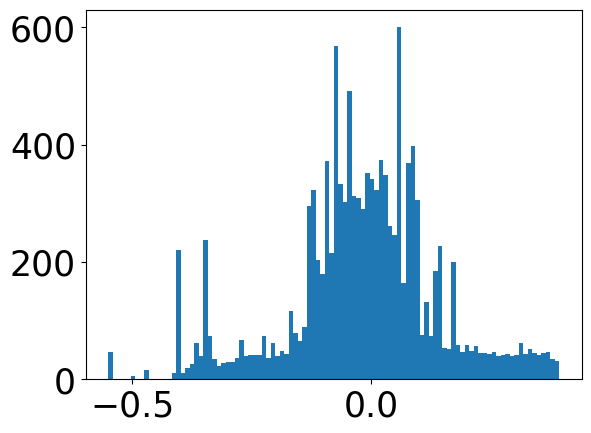

In [188]:
# --------------------------------------------------------------#
# Prepare noise r and theta data for unsupervised learning HMM1  
# --------------------------------------------------------------
from sklearn.model_selection import train_test_split
# df_train,df_test = train_test_split(df_sun,test_size=0.2,random_state=42)
df_train =pd.read_csv('./{}/df_sun_train_{}.csv'.format(sensor,sensor))
noise_observation = list()
for idx in range(0,df_train.shape[0]):
    r_seq = list(df_train.iloc[idx,0].replace("[","").replace("]","").split(","))
    r_seq = [float(i) for i in r_seq]
    theta_seq = list(df_train.iloc[idx,1].replace("[","").replace("]","").split(","))
    theta_seq = [float(i) for i in theta_seq]
    noise_observation.append(np.array([r_seq,theta_seq]).T)
error_theta = []
for traj in noise_observation:
    for ele in traj:
        error_theta.append(ele[1])
plt.hist(error_theta,bins=100)


# Training

In [ ]:
# # set two hidden states
# SHMM = UnSupervisedIOHMM(num_states=3, max_EM_iter=100, EM_tol=1e-6)

# # This model has only one output which is modeled by a linear regression model
# SHMM.set_models(model_emissions = [OLS(),OLS()], 
#                 model_transition=CrossEntropyMNL(solver='lbfgs'),
#                 model_initial=CrossEntropyMNL(solver='lbfgs'))

# # We don't set any covariates to this OLS model
# SHMM.set_inputs(covariates_initial = [], covariates_transition = [], covariates_emissions = [[],[]])

# # # This OLS has only one output target, which is 'rt' column in the dataframe
# # # we only have a list of one sequence.
# # Get two columns of datafrom df_sun in for loop
# for i in range(0,df_sun.shape[1]-1,4):
#     # print('Round{}'.format(i))
#     df_selected = df_sun.iloc[:,i:i+4]
#     df = df_selected[df_selected.notnull().all(axis=1)]
#     # print(df)
#     # print(type(df['DT'][0]))
#     SHMM.set_outputs([['DT_R'],['DT_theta']])
#     SHMM.set_data([df])
#     SHMM.train()

In [ ]:
# # The coefficients of the OLS model for each hidden states
# print("Coeff. of OLS model for each hidden states")
# print(SHMM.model_emissions[0][0].coef)
# print(SHMM.model_emissions[1][0].coef)
# print(SHMM.model_emissions[2][0].coef)
# print('-'*50)
# # The scale/dispersion of the OLS model for each hidden states
# print('Scale/dispersion of OLS model for each hidden states')
# print(np.sqrt(SHMM.model_emissions[0][0].dispersion))
# print(np.sqrt(SHMM.model_emissions[1][0].dispersion))
# print('-'*50)

# # The transition probability between two hidden states
# print('Transition probability between two hidden states')
# print(np.exp(SHMM.model_transition[0].predict_log_proba(np.array([[]]))))
# print(np.exp(SHMM.model_transition[1].predict_log_proba(np.array([[]]))))
# print(np.exp(SHMM.model_transition[2].predict_log_proba(np.array([[]]))))


Statistics of dataset for exp

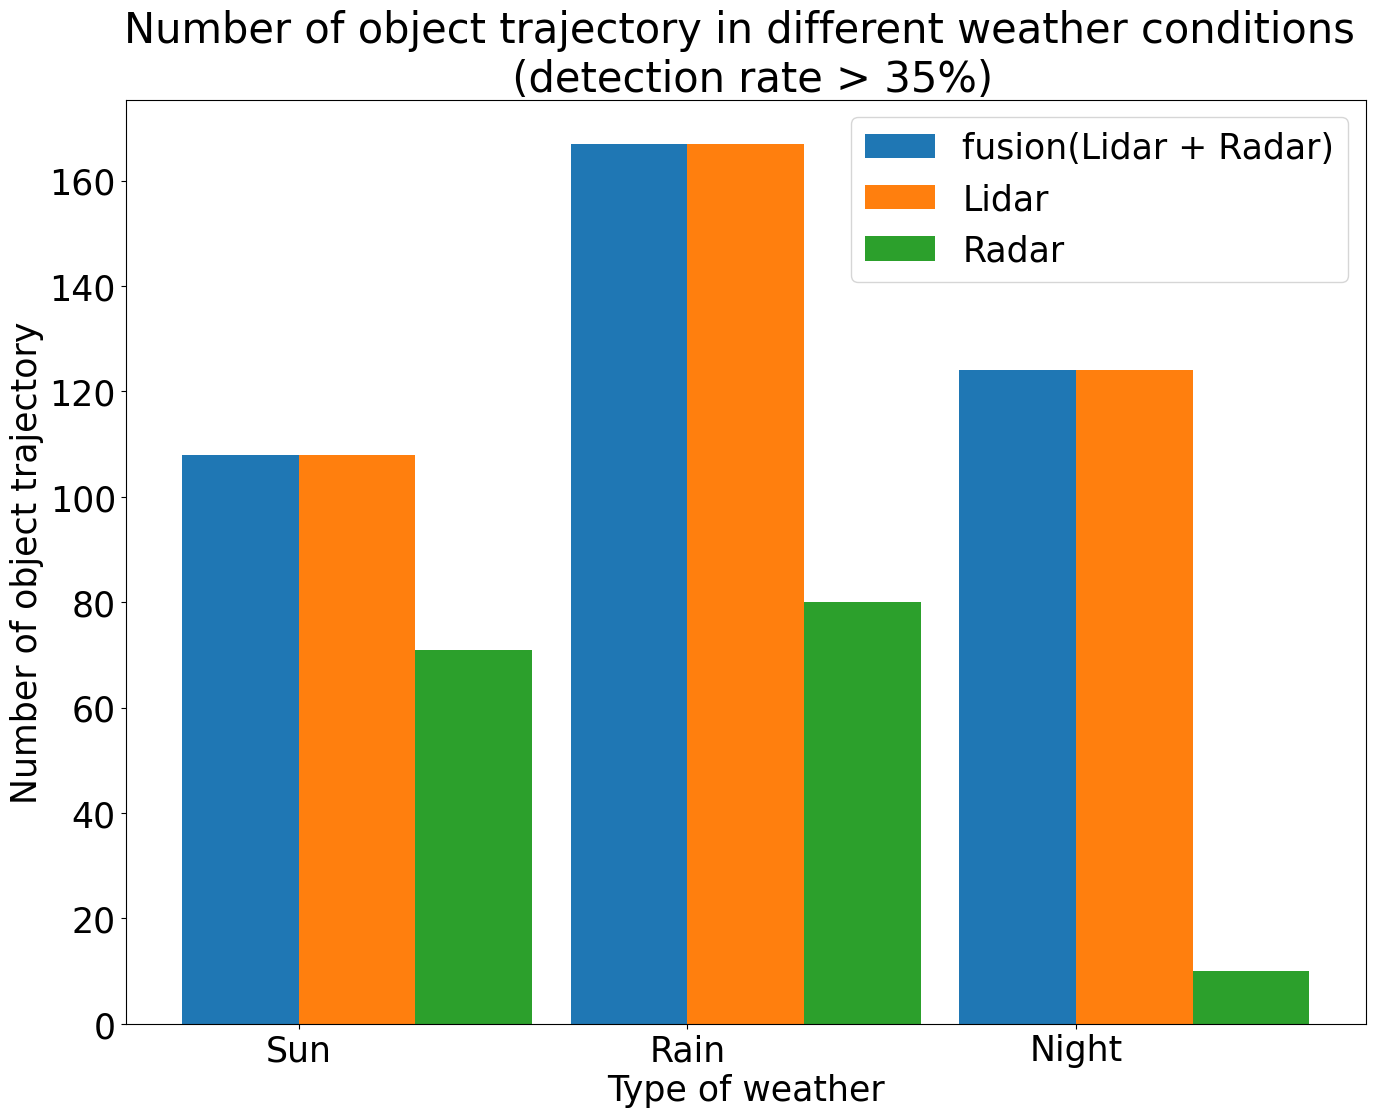

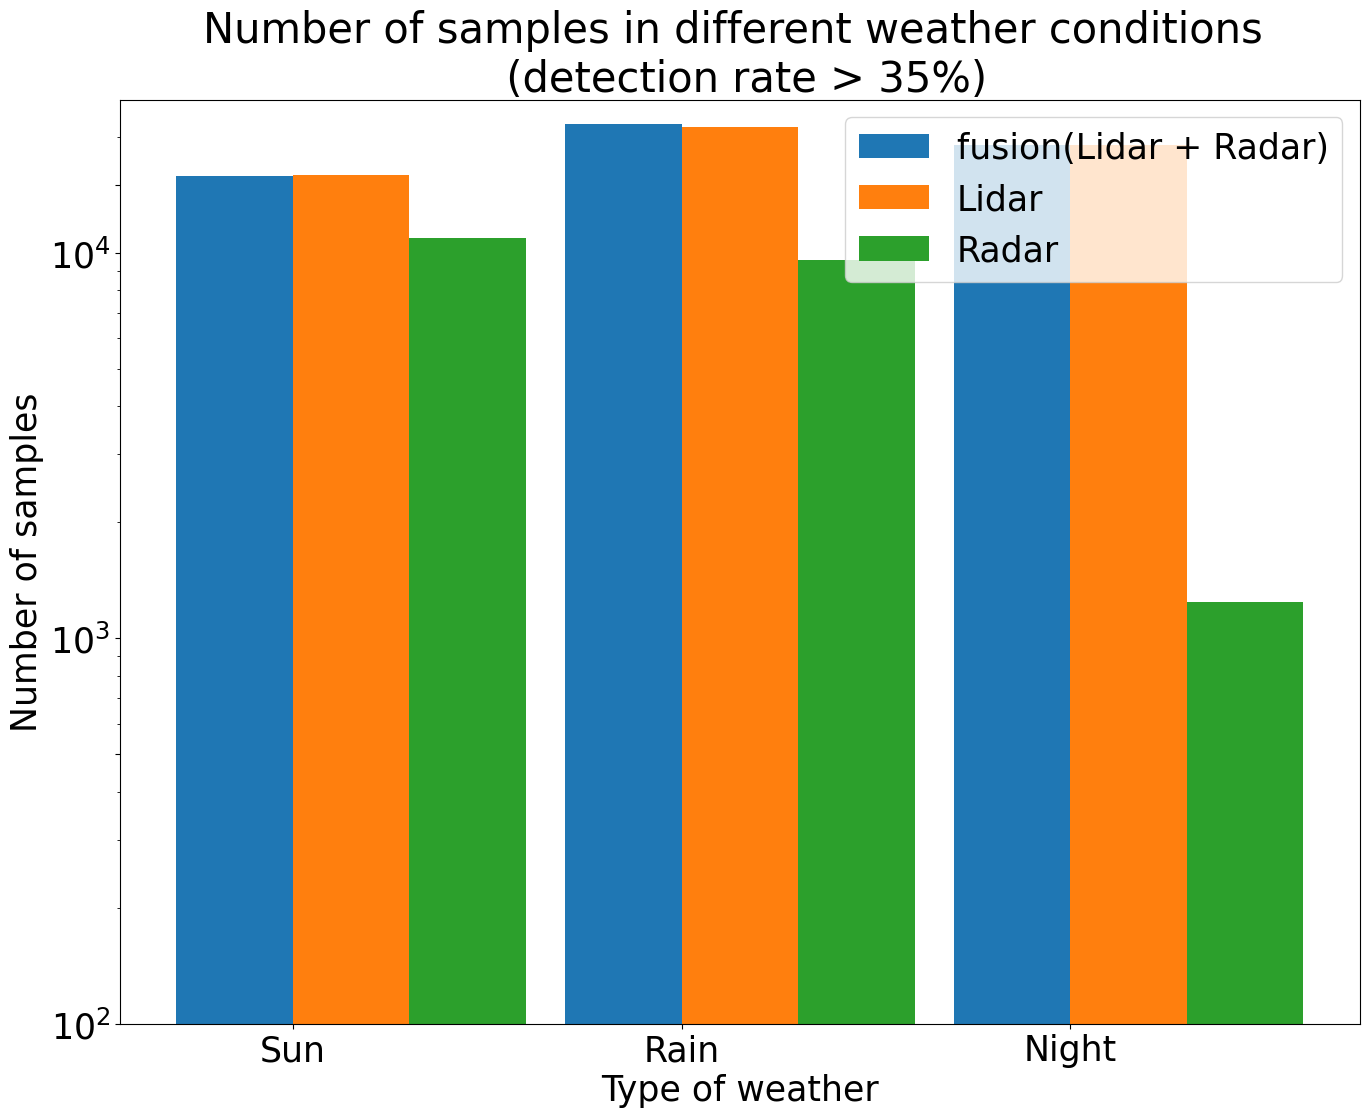

In [39]:
# in order of fusion, lidar, radar
nbr_traj_sun =(108,108,71)
nbr_traj_night = (124, 124,10)
nbr_traj_rain = (167,165,80) 

nbr_samples_sun = (15887,15887,10962)
nbr_samples_night = (19022,19022,1246)
nbr_samples_rain = (21652,21235,9603)

# Sun,rain, night
radar_traj = (71,80,10)
lidar_traj =  (108,167,124)
fusion_traj =  (108,167,124)

radar_samples = (10962,9603,1246)
lidar_samples = (15897,21235,19022)
fusion_samples = (15877,21652,19022)
# traj = [nbr_traj_sun,nbr_traj_night,nbr_traj_rain]
# samples = [nbr_samples_sun,nbr_samples_night,nbr_samples_rain]
ind = np.arange(3)
fig,ax = plt.subplots(1,1,figsize=(16,12))
plt.rcParams.update({'font.size': 25})
width = 0.3   


ax.bar(ind,fusion_traj,width,label='fusion(Lidar + Radar)')
ax.bar(ind + width, lidar_traj, width, label='Lidar')
ax.bar(ind+2*width, radar_traj , width, label='Radar')
# ax[0].xlabel('Type of weather')
ax.set_xlabel('Type of weather')
# ax[0].ylabel('Number of object trajectory')
ax.set_ylabel('Number of object trajectory')
ax.set_title('Number of object trajectory in different weather conditions \n (detection rate > 35%)')
ax.set_xticks(ind + width / 2, ('Sun', 'Rain', 'Night'))
ax.legend(loc='best')
#
fig,ax = plt.subplots(1,1,figsize=(16,12))
plt.rcParams.update({'font.size': 25})
width = 0.3  

ax.bar(ind,fusion_samples,width,label='fusion(Lidar + Radar)')
ax.bar(ind + width, lidar_samples, width, label='Lidar')
ax.bar(ind+2*width, radar_samples , width, label='Radar')
ax.set_xlabel('Type of weather')
ax.set_ylabel('Number of samples')
ax.set_title('Number of samples in different weather conditions \n (detection rate > 35%)')
ax.set_xticks(ind + width / 2, ('Sun', 'Rain', 'Night'))
ax.legend(loc='best')
ax.set_yscale('log')
#
ax.set_yticks([1e2,5e2,1e3,1e4,1.5e4])
plt.show()

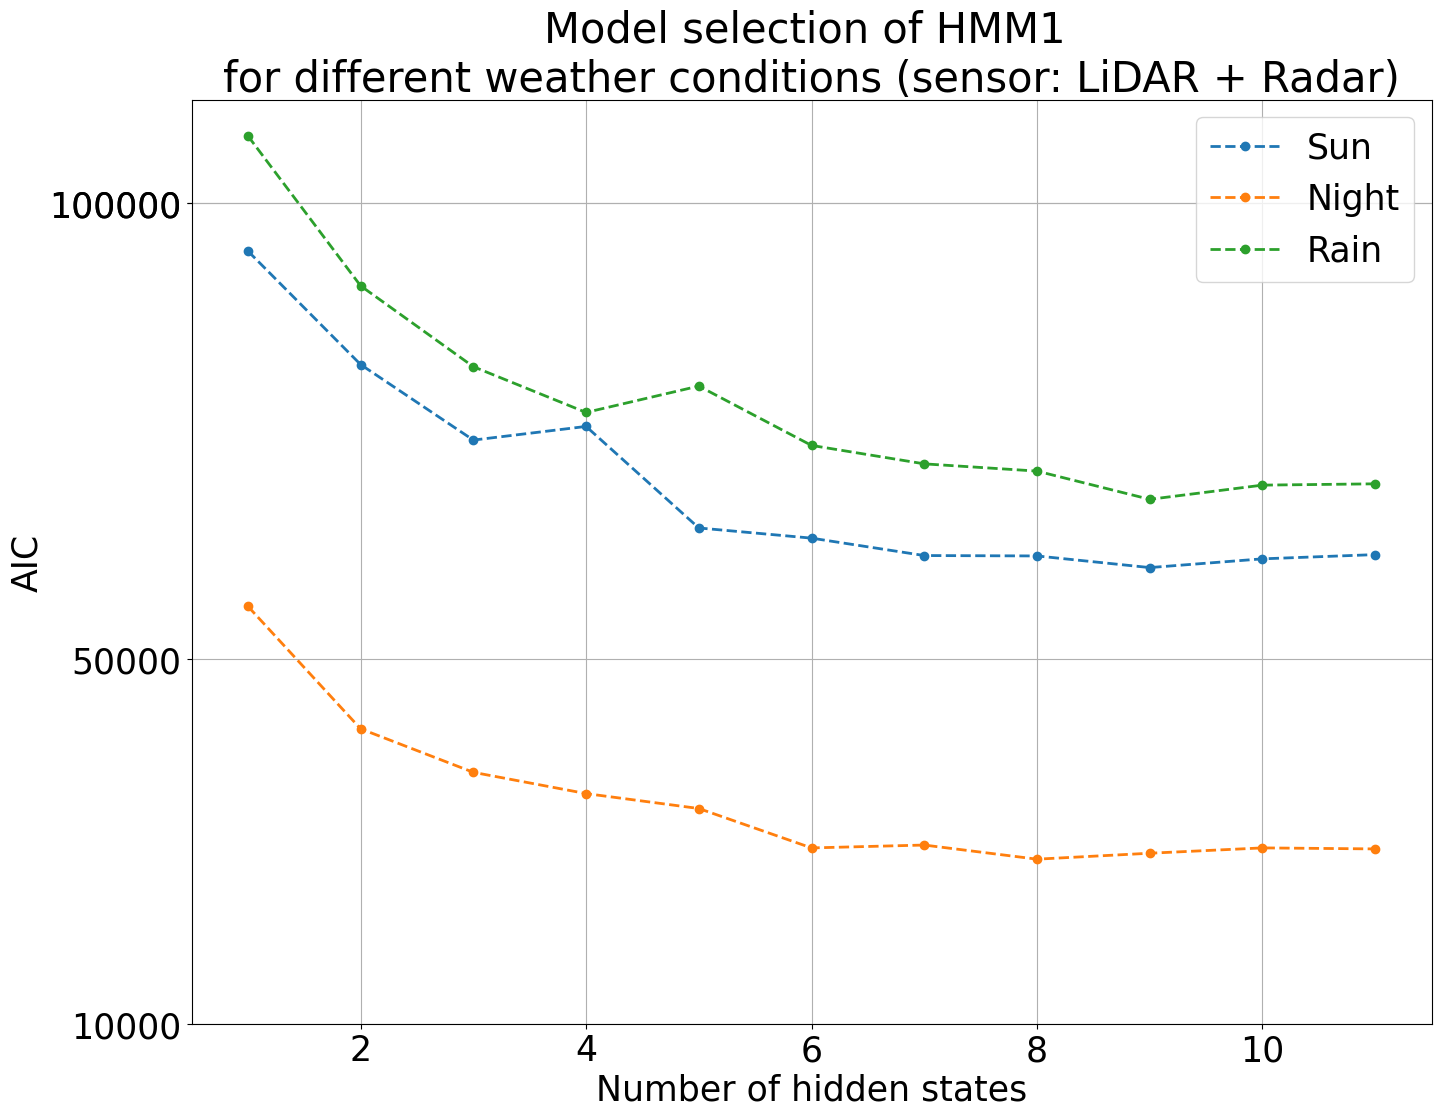

In [78]:

nbr_of_state = [i for i in range(1,12)]
fig,ax = plt.subplots(1,1,figsize=(16,12))
plt.rcParams.update({'font.size': 25})
AIC_sun_modeling_noise = [94735,82287,74002,75500,64366,63250,61341,61297,60021,60979,61444]
AIC_night_modeling_noise = [55776.179,42341.796,37569.311,35237.777,33601.131,29279.225,29593.925,28044.419,28696.405,29281.449,29169.295]
AIC_rain_modeling_noise = [107361,90918.393,82051.191,77033.709,79924.566,73417.472,71395.711,70601.461,67505.116,69062.903,69205.775]
plt.plot(nbr_of_state,AIC_sun_modeling_noise,'--o',linewidth=2,label='Sun')
plt.plot(nbr_of_state,AIC_night_modeling_noise,'--o',linewidth=2,label='Night')
plt.plot(nbr_of_state,AIC_rain_modeling_noise,'--o',linewidth=2,label='Rain')
plt.title('Model selection of HMM1 \nfor different weather conditions (sensor: LiDAR + Radar)')
plt.legend(loc='best')
plt.ylabel(f'AIC')
plt.xlabel('Number of hidden states')

plt.yticks([1e4,5e4,1e5,1e5])
plt.grid()

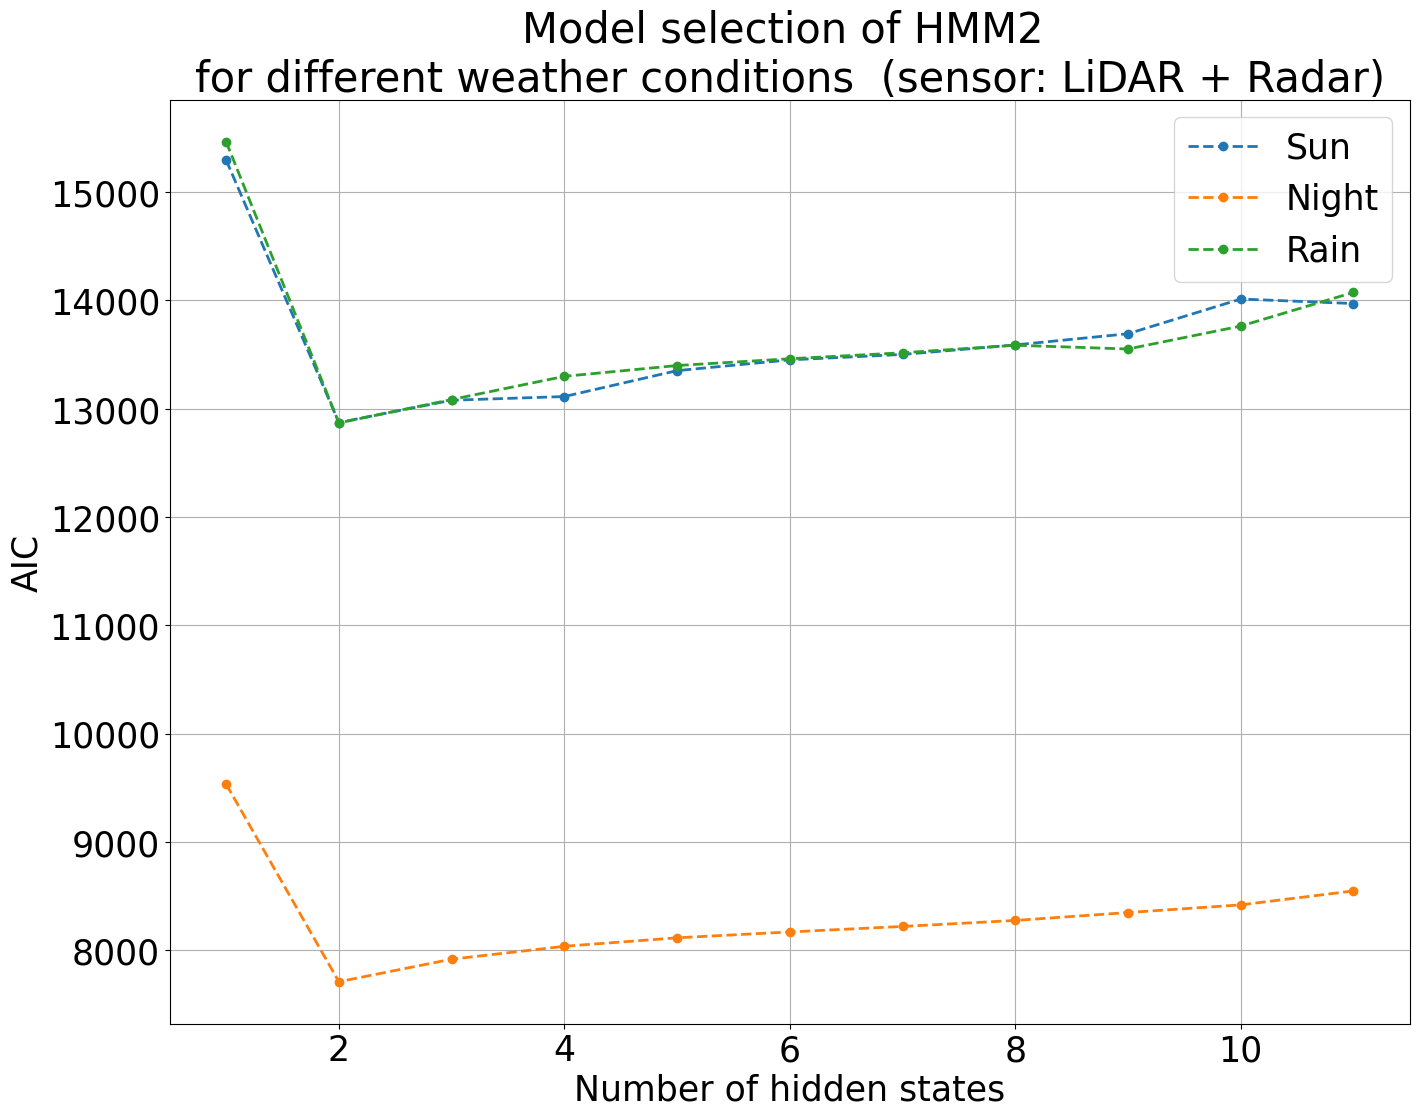

In [79]:
nbr_of_state = [i for i in range(1,12)]

nbr_of_state = [i for i in range(1,12)]
fig,ax = plt.subplots(1,1,figsize=(16,12))
plt.rcParams.update({'font.size': 25})
AIC_sun_modeling_md = [15297.112,12872.695,13078.695,13112.744,13352.074,13451.534,13501.537,13589.435,13692.738,14013.331,13971.731]
AIC_night_modeling_md = [9532.552,7708.105,7916.222,8035.365,8113.768,8167.857,8218.685,8273.921,8347.094,8417.847,8546.721]
AIC_rain_modeling_md = [15466.242,12869.213,13085.090,13299.280,13399.167,13461.825,13516.983,13586.458,13551.819,13763.474,14074.799]
plt.plot(nbr_of_state,AIC_sun_modeling_md,'--o',linewidth=2,label='Sun')
plt.plot(nbr_of_state,AIC_night_modeling_md,'--o',linewidth=2,label='Night')
plt.plot(nbr_of_state,AIC_rain_modeling_md,'--o',linewidth=2,label='Rain')
plt.title('Model selection of HMM2 \nfor different weather conditions  (sensor: LiDAR + Radar)')
plt.legend(loc='best')
plt.ylabel(f'AIC')
plt.xlabel('Number of hidden states')
# plt.yscale('log')
# plt.yticks([5e3,7e3,8e3,9e3, 1e4])
plt.grid()